## 0 - Bibliotecas

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import warnings
import pickle
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
warnings.filterwarnings("ignore")

### 0.1 - Funções utilizadas

##### `my_summary` exibe uma série de informações de uma determina variável

In [2]:
def my_summary(data, column):
    fig, axs = plt.subplots(1,2, figsize=(19,6))
    #creating histogram plot
    axs[0].hist(data[column]) 

    #vertical line for mean of the distribution
    axs[0].axvline(
        data[column].mean(), 
        color='red', 
        label=f"Mean: {round(data[column].mean(),2)}") 

    #vertical line for median of the distribution
    axs[0].axvline(
        data[column].median(), 
        color='green', 
        label=f"Median: {round(data[column].median(),2)}") 

    #vertical line for 25th percentile of the distribution
    axs[0].axvline(
        x=data[column].describe()[4],
        color='r', linestyle='--', 
        label=f"25th percentile: {data[column].describe()[4]}") 

    #vertical line for 75th percentile of the distribution
    axs[0].axvline(
        x=data[column].describe()[6],
        color='r', linestyle='--', 
        label=f"75th percentile: {data[column].describe()[6]}")
        
    axs[0].legend()
    
    #creating boxplot
    sns.boxplot(data=data, x=column, ax=axs[1]) 
    #vertical line for the mean of the distribution
    axs[1].axvline(data[column].mean(), color='red') 

    fig.suptitle(f"Histogram and Boxplot of {column}")
    plt.show()
    
    #describe do campo
    print(f"{data[column].describe().round(3)}\n")

    print(f"Range: {data[column].max() - data[column].min()}")
    print(f"Interquartile Range: {data[column].describe()[6] - data[column].describe()[4]}\n")
    print(f"Skewness: {skew(data[data[column].isna()==False][column], bias=True)}")
    print(f"Kurtosis: {kurtosis(data[data[column].isna()==False][column], bias=True)}")

##### `control_scores` apresenta um gráfico de barras com o comparativo dos modelos apresentados. As informações utilizadas são salvas no df_scores

In [42]:
df_scores =  pd.DataFrame(columns=['desc', 'score'])

def control_scores(desc, score, just_show = False, numeric_order=True):
    if just_show == False:
        df_scores.drop(df_scores[(df_scores['desc'] == desc)].index, inplace=True)
        globals()['df_scores'] =  pd.DataFrame(globals()['df_scores']).append({'desc':desc, 'score':score }, ignore_index=True)

        fig = px.bar(
            df_scores.sort_values(by=['score'], ascending=False), 
            x="score", 
            y="desc", 
            color='desc', 
            orientation='h',
            text_auto=True,

            hover_data=["desc", "score"],
            title='Resultado dos modelos (quanto maior melhor)')
        fig.show()

##### `matriz_confusao`, como o nome já diz, trás a matriz de confusão de um determinado modelo.

In [68]:
def matriz_confusao(model, x_train, y_train, x_test, y_test):
    cm = ConfusionMatrix(model)
    cm.fit(x_train, y_train)
    return cm.score(x_test, y_test)

## 1 - Importação da base do censu

 - `age`             continuous.
 - `workclass`       Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
 - `fnlwgt`          The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are: 1. A single cell estimate of the population 16+ for each state. 2. Controls for Hispanic Origin by age and sex. 3. Controls by Race, age and sex..
 - `education`       Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
 - `education-num`   continuous.
 - `marital-status`  Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
 - `occupation`      Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
 - `relationship`    Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
 - `race`            White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
 - `sex`             Female, Male.
 - `capital-gain`    continuous.
 - `capital-loss`    continuous.
 - `hours-per-week`  continuous.
 - `native-country`  United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [4]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

censu = pd.read_csv(
    'adult.data', 
    sep = ',', 
    header = None,
    names = col_names,
    index_col = False,
    #para remover o espaço em branco no início de cada string que está no arquivo CSV
    #uma outra forma de resolver seria usando o comando abaixo para cada variável do tipo Serie
    #censu.workclass = censu.workclass.str.strip()
    skipinitialspace = True
    )
del(col_names)

## 2 - Análise Descritiva

### Verificação de dados nulos

In [5]:
#ao verificarmos a quantidade de linhas em branco, observamos que a linha loan_int_rate possui quantidade expressova de dados em branco.
censu.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### Verificação da renda (income)

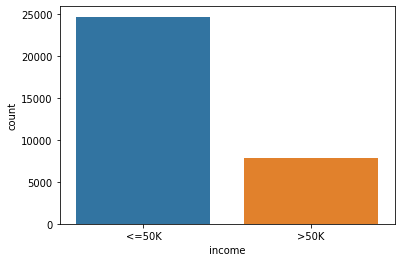

In [6]:
sns.countplot(x = censu['income']);

### Visão de age de acordo com cada workclass

O tamanho do bloco mostra a representatividade

In [7]:
grafico = px.treemap(censu, path=['workclass', 'age'])
grafico.show()
del(grafico)

## 3 - Preparação dos dados

Separa os dados nas variáveis em:

 - `preditoras (x)`: utilizadas para ensinar o modelo
 - `resposta (y)`: valor que desejamos encontrar

In [8]:
# utilizaremos todas as variáveis da base, com excessão de: income (variável y) e educatuon-num
x_censu = censu[censu.columns[~censu.columns.isin(['index', 'income', 'education-num'])]]
y_censu = censu.income

Para cada coluna categórica será criada uma coluna semelhante com classificação numérica para que possa ser utilizada em modelos que não permitam o uso de dados assim. Este processo é chamado de `Label encoding`

In [9]:
from sklearn.preprocessing import LabelEncoder

for column in x_censu:
    if x_censu[column].dtype == object:
        #print(column + '_encoded')
        label_encoder = LabelEncoder()
        x_censu[str(column) + '_encoded'] = label_encoder.fit_transform(x_censu[column])


del(label_encoder)
del(column)

Os dados serão salvos no arquivo `censu.pkl` para que possam ser utilizado nos modelos sem a necessidade de novo carregamento e transformação

In [10]:
import pickle

with open('censu.pkl', mode = 'wb') as f:
  pickle.dump([x_censu, y_censu], f)

del(f)

Para utilização dos dados serão criadas duas funções para retorna as variáveis x e y de acordo com o modelo desejado (label encoding ou dummies)

- `get_dados_variaveis_categoricas` irá retornar 
- `get_dados_variaveis_dummies` permite uma outra forma de trabalhar com dados categóricos utilizando variáveis dummies, onde ao invés de um campo numérico com o identificador de cada categoria são criadas colunas com valores binários (0 e 1) para cada categoria de cada variável.

In [70]:
def get_dados_variaveis_categoricas(padronizar = False):
    # abertura dos arquivo com os dados de X e Y
    with open('censu.pkl', 'rb') as f:
        x_censu, y_censu = pickle.load(f)

    # seleção das colunas que permanecerão no datafrane, neste caso as numéricas e categóricas transformadas
    names = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_encoded', 'education_encoded', 'marital-status_encoded', 'occupation_encoded', 'relationship_encoded', 'race_encoded', 'sex_encoded', 'native-country_encoded']
    x_censu = x_censu[names]

    #  A padronização dos dados iguala o range de valores em todas as variáveis numéricas da base
    if padronizar == True:
        scaler = StandardScaler()
        #a padronização dos dados é feita apenas com as colunas numéricas
        x_censu = scaler.fit_transform(x_censu)

    return train_test_split(x_censu, y_censu, test_size = 0.25, random_state = 0)

Ao invés de partirmos para a utilizarmos as variáveis categóricas convertidas em valores numéricos (variáveis com sufixo _encoded) vamos primeiro verificar quais caregorias possuem mais valores únicos. Para isso utilizaremos inicialmente a base **x_censu** com as variáveis preditoras sem a quebra de teste e treino

As variáveis `education`, `occupation` e `native-country` são as que possuem maiores categorias e podem ser transformadas de forma diferente.

In [69]:
def get_dados_variaveis_dummies(padronizar=False):
    
    #abertura do arquivo com as variáveis x e y
    with open('censu.pkl', 'rb') as f:
        x_censu, y_censu  = pickle.load(f)

    # criação das variáveis dummies para as variáveis preditoras (x)
    x_censu = pd.get_dummies(
        x_censu, 
        #qual será o prefixo das colunas, manteremos o nome original
        prefix=['workclass', 'occupation', 'native-country'],
        #quais colunas serão avaliadas
        columns = ['workclass', 'occupation', 'native-country'],  
        #indicamos que desejamos que primeiro valor seja removido, uma vez que estamos trabalhando com variáveis binárias
        #podemos remover um dos valores categóricos para reduzir a quantidade de colunas, a presença dele pode ser detectada
        #ao verificar se as colunas remanecentes possuem valor 0
        drop_first = False
    )

    # seleção final de colunas separando aquelas que não permanecerão no dataframe
    x_censu = x_censu[x_censu.columns[~x_censu.columns.isin([
        'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 
        'workclass_encoded', 'occupation_encoded', 'native-country_encoded'
    ])]]

    #  A padronização dos dados iguala o range de valores em todas as variáveis numéricas da base
    if padronizar == True:
        scaler = StandardScaler()
        #a padronização dos dados é feita apenas com as colunas numéricas
        x_censu = scaler.fit_transform(x_censu)

    return train_test_split(x_censu, y_censu, test_size = 0.25, random_state = 0)        

## 4 - Naive Bayes

### 4.1 - Label encoding

Começaremos pelo modelo mais simples, o Naive Bayes, com a configuração padrão de padronização de variáveis.

In [65]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_categoricas(padronizar = True)

Criação e execução do modelo

In [66]:
from sklearn.naive_bayes import GaussianNB

naive_censu = GaussianNB()
naive_censu.fit(x_censu_treino, y_censu_treino)
previsoes = naive_censu.predict(x_censu_teste)

control_scores('Naive Bayes - label encoding (com padronização)', accuracy_score(y_censu_teste, previsoes))

Matriz de confusão

0.7978135364205872

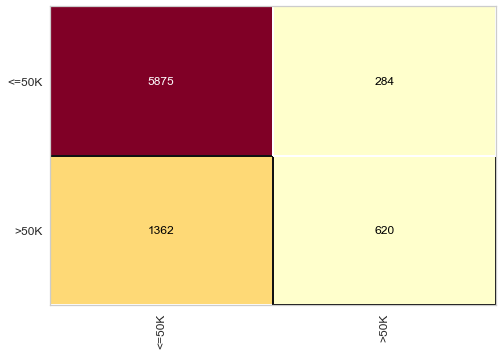

In [67]:
matriz_confusao(naive_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste)


In [46]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_categoricas(padronizar = False)

naive_censu = GaussianNB()
naive_censu.fit(x_censu_treino, y_censu_treino)
previsoes = naive_censu.predict(x_censu_teste)

control_scores('Naive Bayes - label encoding (sem padronização)', accuracy_score(y_censu_teste, previsoes))

### 4.2 - Utilização de variáveis dummies

Utilizaremos a função `get_dados_variaveis_dummies` para obder os dados de treino e teste. Esta função fará a criação das colunas dummies.

In [22]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_dummies(padronizar=False)

**Criação e execução do modelo**

In [47]:
from sklearn.naive_bayes import GaussianNB

naive_censu_dummy = GaussianNB()
naive_censu_dummy.fit(x_censu_treino, y_censu_treino)
previsoes = naive_censu_dummy.predict(x_censu_teste)

control_scores('Naive Bayes - variaveis dummies', accuracy_score(y_censu_teste, previsoes))


**Matriz de confusão**

Podemos observar que não houve mudança na acuracidade do modelo

0.7941284854440487

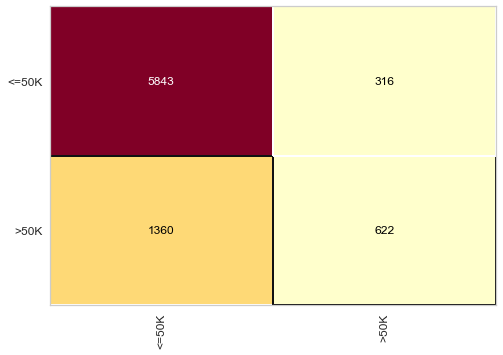

In [24]:
matriz_confusao(naive_censu_dummy, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste)

## 5 - Árvore de decisão

O que são...

In [48]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_categoricas()

Criação e execução do modelo

In [49]:
from sklearn.tree import DecisionTreeClassifier

arvore_census = DecisionTreeClassifier(criterion='entropy', random_state=0)
arvore_census.fit(x_censu_treino, y_censu_treino)

previsoes = arvore_census.predict(x_censu_teste)

control_scores('Árvore de decisão', accuracy_score(y_censu_teste, previsoes))


In [ ]:
matriz_confusao(arvore_census, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste)

## 6 - Randon Forests


#### 6.1 - Variáveis categóricas

In [51]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_categoricas()

In [52]:
from sklearn.ensemble import RandomForestClassifier 
random_forest = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0)
random_forest.fit(x_censu_treino, y_censu_treino)
previsoes = random_forest.predict(x_censu_teste)

control_scores('Randon Forests - Variáveis Categóricas', accuracy_score(y_censu_teste, previsoes))

0.7565409654833558

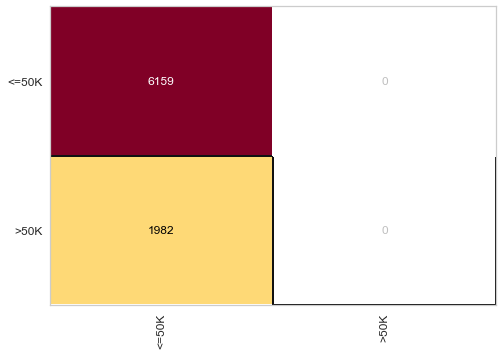

In [71]:
matriz_confusao(arvore_census, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste)

#### 6.2 - Variáveis Dummies

In [53]:
x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = get_dados_variaveis_dummies()

In [54]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0)
random_forest.fit(x_censu_treino, y_censu_treino)
previsoes = random_forest.predict(x_censu_teste)

control_scores('Randon Forests - Variáveis dummies', accuracy_score(y_censu_teste, previsoes))

0.8505097653850878

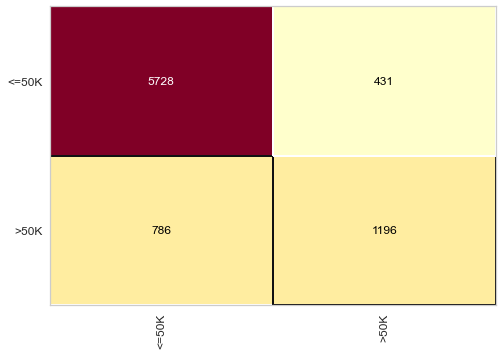

In [38]:
matriz_confusao(random_forest, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste)